# Implemetation for t-SNE using Numpy
- Keyword
  - Setting Cost Function using KL Divergence
  - Gradient Descent
- Sources : [link](https://towardsdatascience.com/t-sne-python-example-1ded9953f26)

In [1]:
import numpy as np

# 데이터셋
from sklearn.datasets import load_digits

# 계산
from scipy.spatial.distance import pdist # 원소 간 쌍을 이룬 거리 계산
from sklearn.manifold._t_sne import _joint_probabilities # t-sne 고차원 상에서 조건부확률 p_ij 계산
from scipy import linalg # 선형대수 계산 라이브러리
from sklearn.metrics import pairwise_distances # 원소 간 쌍을 이룬 거리 계산
from scipy.spatial.distance import squareform # 거리벡터 <-> 거리행렬 변환

# sklearn의 TSNE
from sklearn.manifold import TSNE

# 시각화
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
X, y = load_digits(return_X_y=True)

In [13]:
X.shape

(1797, 64)

In [3]:
n_components = 2
perplexity = 30

In [105]:
distances = pairwise_distances(X, metric='euclidean', squared=True)

# 데이터쌍들의 조건부확률 계산
P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)

X_embedded = 1e-4 * np.random.mtrand._rand.randn(1797, n_components).astype(np.float32)
X_embedded = X_embedded.ravel().reshape(1797, n_components) # (1797, 2)

dist = pdist(X_embedded, "sqeuclidean") 
dist += 1.
dist **= -1
Q = dist / (2.0 * np.sum(dist))


kl_divergence = 2.0 * np.dot(P, np.log(P / Q))
squareform((P - Q) * dist).shape

(1797, 1797)

In [88]:
def fit(X):
  n_samples = X.shape[0]
  
  # 데이터쌍들의 유클리디안 거리 계산 
  distances = pairwise_distances(X, metric='euclidean', squared=True)
  
  # 데이터쌍들의 조건부확률 계산
  P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
  
  # 표준편차가 1e-4인 가우스분포를 따르는 무작위 값을 추출 (y 초기값) # (1797, 2)
  X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
  
  return _tsne(P, n_samples, X_embedded=X_embedded)


def _tsne(P, n_samples, X_embedded):
  params = X_embedded.ravel() # (3594, )
    
  obj_func = _kl_divergence
    
  params = _gradient_descent(obj_func, params, [P, n_samples, n_components])
        
  X_embedded = params.reshape(n_samples, n_components)
  
  return X_embedded


def _kl_divergence(params, P, n_samples, n_components):
  X_embedded = params.reshape(n_samples, n_components) # (1797, 2)

  dist = pdist(X_embedded, "sqeuclidean") # (1613706,)
  dist += 1.
  dist **= -1
  Q = dist / (2.0 * np.sum(dist)) 

  # Kullback-Leibler divergence of P and Q
  kl_divergence = 2.0 * np.dot(P, np.log(P / Q)) # 상수

  # Gradient: dC/dY
  grad = np.ndarray((n_samples, n_components), dtype=params.dtype) # (1797, 2)
  PQd = squareform((P - Q) * dist) # (1797, 1797)
  for i in range(n_samples):
      grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                        X_embedded[i] - X_embedded)
  grad = grad.ravel()
  grad *= 4

  return kl_divergence, grad


def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
  p = p0.copy().ravel()
  update = np.zeros_like(p)
  gains = np.ones_like(p)
  error = np.finfo(np.float).max
  best_error = np.finfo(np.float).max
  best_iter = i = it
    
  for i in range(it, n_iter):
    error, grad = obj_func(p, *args)
    grad_norm = linalg.norm(grad)
    inc = update * grad < 0.0
    dec = np.invert(inc)
    gains[inc] += 0.2
    gains[dec] *= 0.8
    np.clip(gains, min_gain, np.inf, out=gains)
    grad *= gains
    update = momentum * update - learning_rate * grad
    p += update
    print("[t-SNE] Iteration %d: error = %.7f,"
                          " gradient norm = %.7f"
                          % (i + 1, error, grad_norm))
          
    if error < best_error:
      best_error = error
      best_iter = i
    elif i - best_iter > n_iter_without_progress:
      break

    if grad_norm <= min_grad_norm:
      break
    
  return p

In [89]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 3.9810953, gradient norm = 0.0000046
[t-SNE] Iteration 2: error = 3.9810953, gradient norm = 0.0000047
[t-SNE] Iteration 3: error = 3.9810953, gradient norm = 0.0000057
[t-SNE] Iteration 4: error = 3.9810953, gradient norm = 0.0000086
[t-SNE] Iteration 5: error = 3.9810952, gradient norm = 0.0000145
[t-SNE] Iteration 6: error = 3.9810951, gradient norm = 0.0000261
[t-SNE] Iteration 7: error = 3.9810945, gradient norm = 0.0000499
[t-SNE] Iteration 8: error = 3.9810921, gradient norm = 0.0001010
[t-SNE] Iteration 9: error = 3.9810815, gradient norm = 0.0002149
[t-SNE] Iteration 10: error = 3.9810283, gradient norm = 0.0004798
[t-SNE] Iteration 11: error = 3.9807387, gradient norm = 0.0011188
[t-SNE] Iteration 12: error = 3.9790335, gradient norm = 0.0026990
[t-SNE] Iteration 13: error = 3.9685517, gradient norm = 0.0064557
[t-SNE] Iteration 14: error = 3.9107226, gradient norm = 0.0130668
[t-SNE] Iteration 15: error = 3.7100097, gradient norm = 0.0174179
[t-S

<AxesSubplot:>

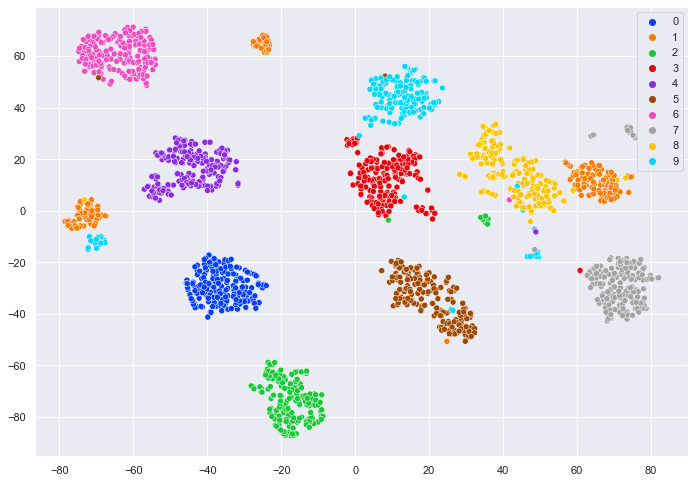

In [72]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

## Implementation for t-SNE using `scikit-learn`

In [73]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

<AxesSubplot:>

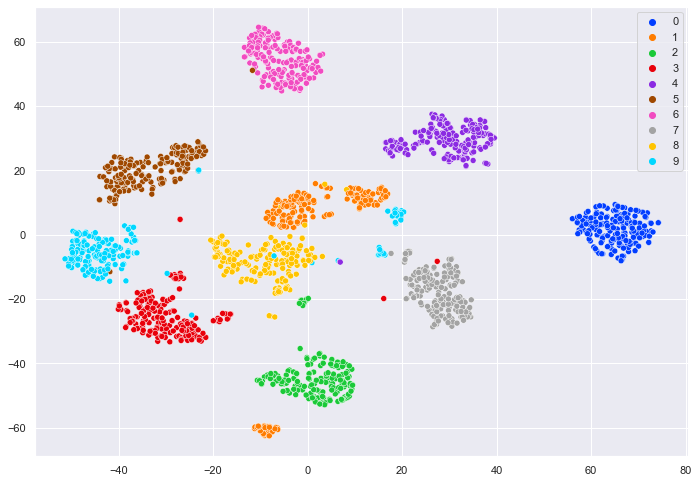

In [74]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)